# Download dataset: https://www.dropbox.com/t/Sb2Vo6S1NrjFdUh9

# 1. Neural Graph Collaborative Filtering

## 1.1. NGCF class construction

In [100]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NGCF(nn.Module):
    def __init__(self, n_user, n_item, norm_adj, args):
        super(NGCF, self).__init__()
        self.n_user = n_user
        self.n_item = n_item
        self.device = args.device
        self.emb_size = args.embed_size
        self.batch_size = args.batch_size
        self.node_dropout = args.node_dropout[0]
        self.mess_dropout = args.mess_dropout
        self.batch_size = args.batch_size

        self.norm_adj = norm_adj

        self.layers = eval(args.layer_size)
        self.decay = eval(args.regs)[0]

        """
        *********************************************************
        Init the weight of user-item.
        """
        self.embedding_dict, self.weight_dict = self.init_weight()

        """
        *********************************************************
        Get sparse adj.
        """
        self.sparse_norm_adj = self._convert_sp_mat_to_sp_tensor(self.norm_adj).to(self.device)

    def init_weight(self):
        # xavier init
        initializer = nn.init.xavier_uniform_

        embedding_dict = nn.ParameterDict({
            'user_emb': nn.Parameter(initializer(torch.empty(self.n_user,
                                                 self.emb_size))),
            'item_emb': nn.Parameter(initializer(torch.empty(self.n_item,
                                                 self.emb_size)))
        })

        weight_dict = nn.ParameterDict()
        layers = [self.emb_size] + self.layers
        for k in range(len(self.layers)):
            weight_dict.update({'W_gc_%d'%k: nn.Parameter(initializer(torch.empty(layers[k],
                                                                      layers[k+1])))})
            weight_dict.update({'b_gc_%d'%k: nn.Parameter(initializer(torch.empty(1, layers[k+1])))})

            weight_dict.update({'W_bi_%d'%k: nn.Parameter(initializer(torch.empty(layers[k],
                                                                      layers[k+1])))})
            weight_dict.update({'b_bi_%d'%k: nn.Parameter(initializer(torch.empty(1, layers[k+1])))})

        return embedding_dict, weight_dict

    def _convert_sp_mat_to_sp_tensor(self, X):
        coo = X.tocoo()
        i = torch.LongTensor([coo.row, coo.col])
        v = torch.from_numpy(coo.data).float()
        return torch.sparse.FloatTensor(i, v, coo.shape)

    def sparse_dropout(self, x, rate, noise_shape):
        random_tensor = 1 - rate
        random_tensor += torch.rand(noise_shape).to(x.device)
        dropout_mask = torch.floor(random_tensor).type(torch.bool)
        i = x._indices()
        v = x._values()

        i = i[:, dropout_mask]
        v = v[dropout_mask]

        out = torch.sparse.FloatTensor(i, v, x.shape).to(x.device)
        return out * (1. / (1 - rate))

    def create_bpr_loss(self, users, pos_items, neg_items):
        pos_scores = torch.sum(torch.mul(users, pos_items), axis=1)
        neg_scores = torch.sum(torch.mul(users, neg_items), axis=1)

        maxi = nn.LogSigmoid()(pos_scores - neg_scores)

        mf_loss = -1 * torch.mean(maxi)

        # cul regularizer
        regularizer = (torch.norm(users) ** 2
                       + torch.norm(pos_items) ** 2
                       + torch.norm(neg_items) ** 2) / 2
        emb_loss = self.decay * regularizer / self.batch_size

        return mf_loss + emb_loss, mf_loss, emb_loss

    def rating(self, u_g_embeddings, pos_i_g_embeddings):
        return torch.matmul(u_g_embeddings, pos_i_g_embeddings.t())

    def forward(self, users, pos_items, neg_items, drop_flag=True):

        A_hat = self.sparse_dropout(self.sparse_norm_adj,
                                    self.node_dropout,
                                    self.sparse_norm_adj._nnz()) if drop_flag else self.sparse_norm_adj

        ego_embeddings = torch.cat([self.embedding_dict['user_emb'],
                                    self.embedding_dict['item_emb']], 0)

        all_embeddings = [ego_embeddings]

        for k in range(len(self.layers)):
            side_embeddings = torch.sparse.mm(A_hat, ego_embeddings)

            # transformed sum messages of neighbors.
            sum_embeddings = torch.matmul(side_embeddings, self.weight_dict['W_gc_%d' % k]) \
                                             + self.weight_dict['b_gc_%d' % k]

            # bi messages of neighbors.
            # element-wise product
            bi_embeddings = torch.mul(ego_embeddings, side_embeddings)
            # transformed bi messages of neighbors.
            bi_embeddings = torch.matmul(bi_embeddings, self.weight_dict['W_bi_%d' % k]) \
                                            + self.weight_dict['b_bi_%d' % k]

            # non-linear activation.
            ego_embeddings = nn.LeakyReLU(negative_slope=0.2)(sum_embeddings + bi_embeddings)

            # message dropout.
            ego_embeddings = nn.Dropout(self.mess_dropout[k])(ego_embeddings)

            # normalize the distribution of embeddings.
            norm_embeddings = F.normalize(ego_embeddings, p=2, dim=1)

            all_embeddings += [norm_embeddings]

        all_embeddings = torch.cat(all_embeddings, 1)
        u_g_embeddings = all_embeddings[:self.n_user, :]
        i_g_embeddings = all_embeddings[self.n_user:, :]

        """
        *********************************************************
        look up.
        """
        u_g_embeddings = u_g_embeddings[users, :]
        pos_i_g_embeddings = i_g_embeddings[pos_items, :]
        neg_i_g_embeddings = i_g_embeddings[neg_items, :]

        return u_g_embeddings, pos_i_g_embeddings, neg_i_g_embeddings


## 1.2. Data object construction

In [101]:
import numpy as np
import random as rd
import scipy.sparse as sp
from time import time

class Data(object):
    def __init__(self, path, batch_size):
        self.path = path
        self.batch_size = batch_size

        train_file = path + '/train.txt'
        test_file = path + '/test.txt'

        #get number of users and items
        self.n_users, self.n_items = 0, 0
        self.n_train, self.n_test = 0, 0
        self.neg_pools = {}

        self.exist_users = []

        with open(train_file) as f:
            for l in f.readlines():
                if len(l) > 0:
                    l = l.strip('\n').split(' ')
                    items = [int(i) for i in l[1:]]
                    uid = int(l[0])
                    self.exist_users.append(uid)
                    self.n_items = max(self.n_items, max(items))
                    self.n_users = max(self.n_users, uid)
                    self.n_train += len(items)

        with open(test_file) as f:
            for l in f.readlines():
                if len(l) > 0:
                    l = l.strip('\n')
                    try:
                        items = [int(i) for i in l.split(' ')[1:]]
                    except Exception:
                        continue
                    self.n_items = max(self.n_items, max(items))
                    self.n_test += len(items)
        self.n_items += 1
        self.n_users += 1

        self.print_statistics()

        self.R = sp.dok_matrix((self.n_users, self.n_items), dtype=np.float32)

        self.train_items, self.test_set = {}, {}
        with open(train_file) as f_train:
            with open(test_file) as f_test:
                for l in f_train.readlines():
                    if len(l) == 0:
                        break
                    l = l.strip('\n')
                    items = [int(i) for i in l.split(' ')]
                    uid, train_items = items[0], items[1:]

                    for i in train_items:
                        self.R[uid, i] = 1.
                        # self.R[uid][i] = 1

                    self.train_items[uid] = train_items

                for l in f_test.readlines():
                    if len(l) == 0: break
                    l = l.strip('\n')
                    try:
                        items = [int(i) for i in l.split(' ')]
                    except Exception:
                        continue

                    uid, test_items = items[0], items[1:]
                    self.test_set[uid] = test_items

    def get_adj_mat(self):
        try:
            t1 = time()
            adj_mat = sp.load_npz(self.path + '/s_adj_mat.npz')
            norm_adj_mat = sp.load_npz(self.path + '/s_norm_adj_mat.npz')
            mean_adj_mat = sp.load_npz(self.path + '/s_mean_adj_mat.npz')
            print('already load adj matrix', adj_mat.shape, time() - t1)

        except Exception:
            adj_mat, norm_adj_mat, mean_adj_mat = self.create_adj_mat()
            sp.save_npz(self.path + '/s_adj_mat.npz', adj_mat)
            sp.save_npz(self.path + '/s_norm_adj_mat.npz', norm_adj_mat)
            sp.save_npz(self.path + '/s_mean_adj_mat.npz', mean_adj_mat)
        return adj_mat, norm_adj_mat, mean_adj_mat

    def create_adj_mat(self):
        t1 = time()
        adj_mat = sp.dok_matrix((self.n_users + self.n_items, self.n_users + self.n_items), dtype=np.float32)
        adj_mat = adj_mat.tolil()
        R = self.R.tolil()

        adj_mat[:self.n_users, self.n_users:] = R
        adj_mat[self.n_users:, :self.n_users] = R.T
        adj_mat = adj_mat.todok()
        print('already create adjacency matrix', adj_mat.shape, time() - t1)

        t2 = time()

        def mean_adj_single(adj):
            # D^-1 * A
            rowsum = np.array(adj.sum(1))

            d_inv = np.power(rowsum, -1).flatten()
            d_inv[np.isinf(d_inv)] = 0.
            d_mat_inv = sp.diags(d_inv)

            norm_adj = d_mat_inv.dot(adj)
            # norm_adj = adj.dot(d_mat_inv)
            print('generate single-normalized adjacency matrix.')
            return norm_adj.tocoo()

        def normalized_adj_single(adj):
            # D^-1/2 * A * D^-1/2
            rowsum = np.array(adj.sum(1))

            d_inv_sqrt = np.power(rowsum, -0.5).flatten()
            d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
            d_mat_inv_sqrt = sp.diags(d_inv_sqrt)

            # bi_lap = adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt)
            bi_lap = d_mat_inv_sqrt.dot(adj).dot(d_mat_inv_sqrt)
            return bi_lap.tocoo()

        def check_adj_if_equal(adj):
            dense_A = np.array(adj.todense())
            degree = np.sum(dense_A, axis=1, keepdims=False)

            temp = np.dot(np.diag(np.power(degree, -1)), dense_A)
            print('check normalized adjacency matrix whether equal to this laplacian matrix.')
            return temp

        norm_adj_mat = mean_adj_single(adj_mat + sp.eye(adj_mat.shape[0]))
        # norm_adj_mat = normalized_adj_single(adj_mat + sp.eye(adj_mat.shape[0]))
        mean_adj_mat = mean_adj_single(adj_mat)

        print('already normalize adjacency matrix', time() - t2)
        return adj_mat.tocsr(), norm_adj_mat.tocsr(), mean_adj_mat.tocsr()

    def negative_pool(self):
        t1 = time()
        for u in self.train_items.keys():
            neg_items = list(set(range(self.n_items)) - set(self.train_items[u]))
            pools = [rd.choice(neg_items) for _ in range(100)]
            self.neg_pools[u] = pools
        print('refresh negative pools', time() - t1)

    def sample(self):
        if self.batch_size <= self.n_users:
            users = rd.sample(self.exist_users, self.batch_size)
        else:
            users = [rd.choice(self.exist_users) for _ in range(self.batch_size)]

        def sample_pos_items_for_u(u, num):
            # sample num pos items for u-th user
            pos_items = self.train_items[u]
            n_pos_items = len(pos_items)
            pos_batch = []
            while True:
                if len(pos_batch) == num:
                    break
                pos_id = np.random.randint(low=0, high=n_pos_items, size=1)[0]
                pos_i_id = pos_items[pos_id]

                if pos_i_id not in pos_batch:
                    pos_batch.append(pos_i_id)
            return pos_batch

        def sample_neg_items_for_u(u, num):
            # sample num neg items for u-th user
            neg_items = []
            while True:
                if len(neg_items) == num:
                    break
                neg_id = np.random.randint(low=0, high=self.n_items,size=1)[0]
                if neg_id not in self.train_items[u] and neg_id not in neg_items:
                    neg_items.append(neg_id)
            return neg_items

        def sample_neg_items_for_u_from_pools(u, num):
            neg_items = list(set(self.neg_pools[u]) - set(self.train_items[u]))
            return rd.sample(neg_items, num)

        pos_items, neg_items = [], []
        for u in users:
            pos_items += sample_pos_items_for_u(u, 1)
            neg_items += sample_neg_items_for_u(u, 1)

        return users, pos_items, neg_items

    def get_num_users_items(self):
        return self.n_users, self.n_items

    def print_statistics(self):
        print('n_users=%d, n_items=%d' % (self.n_users, self.n_items))
        print('n_interactions=%d' % (self.n_train + self.n_test))
        print('n_train=%d, n_test=%d, sparsity=%.5f' % (self.n_train, self.n_test, (self.n_train + self.n_test)/(self.n_users * self.n_items)))

    def get_sparsity_split(self):
        try:
            split_uids, split_state = [], []
            lines = open(self.path + '/sparsity.split', 'r').readlines()

            for idx, line in enumerate(lines):
                if idx % 2 == 0:
                    split_state.append(line.strip())
                    print(line.strip())
                else:
                    split_uids.append([int(uid) for uid in line.strip().split(' ')])
            print('get sparsity split.')

        except Exception:
            split_uids, split_state = self.create_sparsity_split()
            f = open(self.path + '/sparsity.split', 'w')
            for idx in range(len(split_state)):
                f.write(split_state[idx] + '\n')
                f.write(' '.join([str(uid) for uid in split_uids[idx]]) + '\n')
            print('create sparsity split.')

        return split_uids, split_state

    def create_sparsity_split(self):
        all_users_to_test = list(self.test_set.keys())
        user_n_iid = dict()

        # generate a dictionary to store (key=n_iids, value=a list of uid).
        for uid in all_users_to_test:
            train_iids = self.train_items[uid]
            test_iids = self.test_set[uid]

            n_iids = len(train_iids) + len(test_iids)

            if n_iids not in user_n_iid.keys():
                user_n_iid[n_iids] = [uid]
            else:
                user_n_iid[n_iids].append(uid)
        split_uids = list()

        # split the whole user set into four subset.
        temp = []
        count = 1
        fold = 4
        n_count = (self.n_train + self.n_test)
        n_rates = 0

        split_state = []
        for idx, n_iids in enumerate(sorted(user_n_iid)):
            temp += user_n_iid[n_iids]
            n_rates += n_iids * len(user_n_iid[n_iids])
            n_count -= n_iids * len(user_n_iid[n_iids])

            if n_rates >= count * 0.25 * (self.n_train + self.n_test):
                split_uids.append(temp)

                state = '#inter per user<=[%d], #users=[%d], #all rates=[%d]' %(n_iids, len(temp), n_rates)
                split_state.append(state)
                print(state)

                temp = []
                n_rates = 0
                fold -= 1

            if idx == len(user_n_iid.keys()) - 1 or n_count == 0:
                split_uids.append(temp)

                state = '#inter per user<=[%d], #users=[%d], #all rates=[%d]' % (n_iids, len(temp), n_rates)
                split_state.append(state)
                print(state)

        return split_uids, split_state


## 1.4. Metrics: 

precision_at_k, average_precision, mean_average_precision

In [148]:
import numpy as np
from sklearn.metrics import roc_auc_score

def recall(rank, ground_truth, N):
    return len(set(rank[:N]) & set(ground_truth)) / float(len(set(ground_truth)))

def precision_at_k(r, k):
    """Score is precision @ k
    Relevance is binary (nonzero is relevant).
    Returns:
        Precision @ k
    Raises:
        ValueError: len(r) must be >= k
    """
    assert k >= 1
    r = np.asarray(r)[:k]
    return np.mean(r)

def average_precision(r,cut):
    """Score is average precision (area under PR curve)
    Relevance is binary (nonzero is relevant).
    Returns:
        Average precision
    """
    r = np.asarray(r)
    out = [precision_at_k(r, k + 1) for k in range(cut) if r[k]]
    if not out:
        return 0.
    return np.sum(out)/float(min(cut, np.sum(r)))

def mean_average_precision(rs):
    """Score is mean average precision
    Relevance is binary (nonzero is relevant).
    Returns:
        Mean average precision
    """
    return np.mean([average_precision(r) for r in rs])

def dcg_at_k(r, k, method=1):
    """Score is discounted cumulative gain (dcg)
    Relevance is positive real values.  Can use binary
    as the previous methods.
    Returns:
        Discounted cumulative gain
    """
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.

def ndcg_at_k(r, k, ground_truth, method=1):
    """Score is normalized discounted cumulative gain (ndcg)
    Relevance is positive real values.  Can use binary
    as the previous methods.
    Returns:
        Normalized discounted cumulative gain

        Low but correct defination
    """
    GT = set(ground_truth)
    if len(GT) > k :
        sent_list = [1.0] * k
    else:
        sent_list = [1.0]*len(GT) + [0.0]*(k-len(GT))
    dcg_max = dcg_at_k(sent_list, k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max

def recall_at_k(r, k, all_pos_num):
    # if all_pos_num == 0:
    #     return 0
    r = np.asfarray(r)[:k]
    return np.sum(r) / all_pos_num

def hit_at_k(r, k):
    r = np.array(r)[:k]
    if np.sum(r) > 0:
        return 1.
    else:
        return 0.

def F1(pre, rec):
    if pre + rec > 0:
        return (2.0 * pre * rec) / (pre + rec)
    else:
        return 0.

def AUC(ground_truth, prediction):
    try:
        res = roc_auc_score(y_true=ground_truth, y_score=prediction)
    except Exception:
        res = 0.
    return res

## 1.5. Change to NGCF folder

In [103]:
import os
os.chdir(os.path.join(os.getcwd(), 'NGCF'))  # Set the path to NGCF directory if needed.
print(f"Current working directory: {os.getcwd()}")

Current working directory: /home/ubuntu/Documents/Graph-Neural-Networks-Fall-2023/W14/NGCF


## 1.6. Run the main.py code

Open Visual Studio/Pycharm to run the code

In [ ]:
import os
os.system('python main.py --dataset gowalla --regs [1e-5] --embed_size 64 --layer_size [64,64,64] --lr 0.0001 --save_flag 1 --pretrain 0 --batch_size 1024 --epoch 400 --verbose 1 --node_dropout [0.1] --mess_dropout [0.1,0.1,0.1]')

# 2. KGAT: Knowledge Graph Attention Network for Recommendation

## 2.1. Aggregator and KGAT 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# L2 regularization loss, calculates the mean of squared values for a tensor
def _L2_loss_mean(x):
    return torch.mean(torch.sum(torch.pow(x, 2), dim=1, keepdim=False) / 2.)

# Aggregator class for message-passing in GNN
class Aggregator(nn.Module):
    
    def __init__(self, in_dim, out_dim, dropout, aggregator_type):
        super(Aggregator, self).__init__()
        # Initialize dimensions, dropout, and type of aggregator
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.dropout = dropout
        self.aggregator_type = aggregator_type

        # Dropout for message-passing and activation function
        self.message_dropout = nn.Dropout(dropout)
        self.activation = nn.LeakyReLU()

        # Initialize linear transformations based on aggregator type
        if self.aggregator_type == 'gcn':
            # GCN type: single linear layer
            self.linear = nn.Linear(self.in_dim, self.out_dim)
            nn.init.xavier_uniform_(self.linear.weight)
        elif self.aggregator_type == 'graphsage':
            # GraphSAGE type: concatenates input and neighbor embeddings
            self.linear = nn.Linear(self.in_dim * 2, self.out_dim)
            nn.init.xavier_uniform_(self.linear.weight)
        elif self.aggregator_type == 'bi-interaction':
            # Bi-interaction type: uses two linear transformations
            self.linear1 = nn.Linear(self.in_dim, self.out_dim)
            self.linear2 = nn.Linear(self.in_dim, self.out_dim)
            nn.init.xavier_uniform_(self.linear1.weight)
            nn.init.xavier_uniform_(self.linear2.weight)
        else:
            raise NotImplementedError

    # Forward pass for aggregator
    def forward(self, ego_embeddings, A_in):
        """
        Parameters:
        ego_embeddings: user and entity embeddings
        A_in: adjacency matrix as a sparse tensor
        """
        # Neighbor aggregation
        side_embeddings = torch.matmul(A_in, ego_embeddings)

        if self.aggregator_type == 'gcn':
            embeddings = ego_embeddings + side_embeddings
            embeddings = self.activation(self.linear(embeddings))
        elif self.aggregator_type == 'graphsage':
            embeddings = torch.cat([ego_embeddings, side_embeddings], dim=1)
            embeddings = self.activation(self.linear(embeddings))
        elif self.aggregator_type == 'bi-interaction':
            sum_embeddings = self.activation(self.linear1(ego_embeddings + side_embeddings))
            bi_embeddings = self.activation(self.linear2(ego_embeddings * side_embeddings))
            embeddings = bi_embeddings + sum_embeddings

        embeddings = self.message_dropout(embeddings) 
        return embeddings

# Knowledge Graph Attention Network (KGAT) model
class KGAT(nn.Module):
    
    def __init__(self, args, n_users, n_entities, n_relations, A_in=None, user_pre_embed=None, item_pre_embed=None):
        super(KGAT, self).__init__()
        
        # Initialize user and entity embeddings, relation embeddings
        self.embed_dim = args.embed_dim
        self.user_entity_embed = nn.Embedding(n_users + n_entities, self.embed_dim)
        self.relation_embed = nn.Embedding(n_relations, self.embed_dim)
        self.use_pretrain = args.use_pretrain

        # Initialize hyperparameters and structure settings
        self.n_users = n_users
        self.n_entities = n_entities
        self.n_relations = n_relations
        self.relation_dim = args.relation_dim
        self.aggregation_type = args.aggregation_type
        self.conv_dim_list = [args.embed_dim] + eval(args.conv_dim_list)
        self.mess_dropout = eval(args.mess_dropout)
        self.n_layers = len(eval(args.conv_dim_list))
        self.kg_l2loss_lambda = args.kg_l2loss_lambda
        self.cf_l2loss_lambda = args.cf_l2loss_lambda

        # Initialize transformation matrices and embeddings
        self.entity_user_embed = nn.Embedding(self.n_entities + self.n_users, self.embed_dim)
        self.relation_embed = nn.Embedding(self.n_relations, self.relation_dim)
        self.trans_M = nn.Parameter(torch.Tensor(self.n_relations, self.embed_dim, self.relation_dim))

        # Pretrain embedding weights if available
        if (self.use_pretrain == 1) and (user_pre_embed is not None) and (item_pre_embed is not None):
            other_entity_embed = nn.Parameter(torch.Tensor(self.n_entities - item_pre_embed.shape[0], self.embed_dim))
            nn.init.xavier_uniform_(other_entity_embed)
            entity_user_embed = torch.cat([item_pre_embed, other_entity_embed, user_pre_embed], dim=0)
            self.entity_user_embed.weight = nn.Parameter(entity_user_embed)
        else:
            nn.init.xavier_uniform_(self.entity_user_embed.weight)

        # Initialize weights
        nn.init.xavier_uniform_(self.relation_embed.weight)
        nn.init.xavier_uniform_(self.trans_M)

        # Aggregator layers for multi-layer GNN
        self.aggregator_layers = nn.ModuleList()
        for k in range(self.n_layers):
            self.aggregator_layers.append(Aggregator(self.conv_dim_list[k], self.conv_dim_list[k + 1], self.mess_dropout[k], self.aggregation_type))

        # Initialize sparse adjacency matrix
        self.A_in = nn.Parameter(torch.sparse.FloatTensor(self.n_users + self.n_entities, self.n_users + self.n_entities))
        if A_in is not None:
            self.A_in.data = A_in
        self.A_in.requires_grad = False

    # Calculate collaborative filtering embeddings
    def calc_cf_embeddings(self):
        ego_embed = self.entity_user_embed.weight
        all_embed = [ego_embed]

        for idx, layer in enumerate(self.aggregator_layers):
            ego_embed = layer(ego_embed, self.A_in)
            norm_embed = F.normalize(ego_embed, p=2, dim=1)
            all_embed.append(norm_embed)

        all_embed = torch.cat(all_embed, dim=1)
        return all_embed

    # Calculate collaborative filtering loss
    def calc_cf_loss(self, user_ids, item_pos_ids, item_neg_ids):
        all_embed = self.calc_cf_embeddings()
        user_embed = all_embed[user_ids]
        item_pos_embed = all_embed[item_pos_ids]
        item_neg_embed = all_embed[item_neg_ids]

        pos_score = torch.sum(user_embed * item_pos_embed, dim=1)
        neg_score = torch.sum(user_embed * item_neg_embed, dim=1)

        cf_loss = (-1.0) * F.logsigmoid(pos_score - neg_score)
        cf_loss = torch.mean(cf_loss)

        l2_loss = _L2_loss_mean(user_embed) + _L2_loss_mean(item_pos_embed) + _L2_loss_mean(item_neg_embed)
        loss = cf_loss + self.cf_l2loss_lambda * l2_loss
        return loss

    # Calculate knowledge graph loss
    def calc_kg_loss(self, h, r, pos_t, neg_t):
        r_embed = self.relation_embed(r)
        W_r = self.trans_M[r]

        h_embed = self.entity_user_embed(h)
        pos_t_embed = self.entity_user_embed(pos_t)
        neg_t_embed = self.entity_user_embed(neg_t)

        r_mul_h = torch.bmm(h_embed.unsqueeze(1), W_r).squeeze(1)
        r_mul_pos_t = torch.bmm(pos_t_embed.unsqueeze(1), W_r).squeeze(1)
        r_mul_neg_t = torch.bmm(neg_t_embed.unsqueeze(1), W_r).squeeze(1)

        pos_score = torch.sum(torch.pow(r_mul_h + r_embed - r_mul_pos_t, 2), dim=1)
        neg_score = torch.sum(torch.pow(r_mul_h + r_embed - r_mul_neg_t, 2), dim=1)

        kg_loss = (-1.0) * F.logsigmoid(neg_score - pos_score)
        kg_loss = torch.mean(kg_loss)

        l2_loss = _L2_loss_mean(r_mul_h) + _L2_loss_mean(r_embed) + _L2_loss_mean(r_mul_pos_t) + _L2_loss_mean(r_mul_neg_t)
        loss = kg_loss + self.kg_l2loss_lambda * l2_loss
        return loss

    # Update attention scores for entities and relations
    def update_attention_batch(self, h_list, t_list, r_idx):
        r_embed = self.relation_embed.weight[r_idx]
        W_r = self.trans_M[r_idx]

        h_embed = self.entity_user_embed.weight[h_list]
        t_embed = self.entity_user_embed.weight[t_list]

        r_mul_h = torch.matmul(h_embed, W_r)
        r_mul_t = torch.matmul(t_embed, W_r)
        v_list = torch.sum(r_mul_t * torch.tanh(r_mul_h + r_embed), dim=1)
        return v_list

    # Calculate attention for the entire graph
    def update_attention(self, h_list, t_list, r_list, relations):
        device = self.A_in.device

        rows, cols, values = [], [], []

        for r_idx in relations:
            index_list = torch.where(r_list == r_idx)
            batch_h_list = h_list[index_list]
            batch_t_list = t_list[index_list]

            batch_v_list = self.update_attention_batch(batch_h_list, batch_t_list, r_idx)
            rows.append(batch_h_list)
            cols.append(batch_t_list)
            values.append(batch_v_list)

        rows = torch.cat(rows)
        cols = torch.cat(cols)
        values = torch.cat(values)

        indices = torch.stack([rows, cols])
        shape = self.A_in.shape
        A_in = torch.sparse.FloatTensor(indices, values, torch.Size(shape))

        A_in = torch.sparse.softmax(A_in.cpu(), dim=1)
        self.A_in.data = A_in.to(device)

    # Calculate scores for user-item pairs
    def calc_score(self, user_ids, item_ids):
        all_embed = self.calc_cf_embeddings()
        user_embed = all_embed[user_ids]
        item_embed = all_embed[item_ids]

        cf_score = torch.matmul(user_embed, item_embed.transpose(0, 1))
        return cf_score

    # Main forward function with different modes
    def forward(self, *input, mode):
        if mode == 'train_cf':
            return self.calc_cf_loss(*input)
        if mode == 'train_kg':
            return self.calc_kg_loss(*input)
        if mode == 'update_att':
            return self.update_attention(*input)
        if mode == 'predict':
            return self.calc_score(*input)


## 2.2. Log_helper

In [2]:
import os
import logging
import csv
from collections import OrderedDict

# Function to create a unique log ID by incrementing a counter
def create_log_id(dir_path):
    # Initialize the log count at 0
    log_count = 0
    # Create a file path with 'log0.log', 'log1.log', etc., until a unique file name is found
    file_path = os.path.join(dir_path, 'log{:d}.log'.format(log_count))
    while os.path.exists(file_path):
        # Increment log_count and generate a new file path
        log_count += 1
        file_path = os.path.join(dir_path, 'log{:d}.log'.format(log_count))
    return log_count  # Return the unique log ID

# Function to configure logging settings
def logging_config(folder=None, name=None,
                   level=logging.DEBUG,
                   console_level=logging.DEBUG,
                   no_console=True):

    # Create the log folder if it does not exist
    if not os.path.exists(folder):
        os.makedirs(folder)

    # Clear any existing handlers from the root logger
    for handler in logging.root.handlers:
        logging.root.removeHandler(handler)
    logging.root.handlers = []  # Reset handlers to avoid duplicate logs

    # Set the log file path using the provided folder and log name
    logpath = os.path.join(folder, name + ".log")
    print("All logs will be saved to %s" % logpath)

    # Set the logging level for the root logger
    logging.root.setLevel(level)

    # Define the log format
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

    # Create a file handler for logging to a file
    logfile = logging.FileHandler(logpath)
    logfile.setLevel(level)           # Set the level for the file handler
    logfile.setFormatter(formatter)   # Apply the format to the file handler
    logging.root.addHandler(logfile)  # Add the file handler to the root logger

    # Optionally add a console handler to also log to the console
    if not no_console:
        logconsole = logging.StreamHandler()  # Create a stream handler for console output
        logconsole.setLevel(console_level)    # Set the level for console logging
        logconsole.setFormatter(formatter)    # Apply the format to the console handler
        logging.root.addHandler(logconsole)   # Add the console handler to the root logger

    return folder  # Return the log folder path


## 2.3. Metrics

In [3]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, log_loss, mean_squared_error

# Function to calculate recall for a single example at a given cutoff k
def calc_recall(rank, ground_truth, k):
    """
    rank: list of predicted ranked items
    ground_truth: list of true items
    k: top-k items to consider
    """
    return len(set(rank[:k]) & set(ground_truth)) / float(len(set(ground_truth)))

# Function to calculate precision at k for a single user
def precision_at_k(hit, k):
    """
    hit: list of binary values indicating whether top-k items were relevant (1) or not (0)
    """
    hit = np.asarray(hit)[:k]  # Take the first k elements
    return np.mean(hit)  # Compute mean precision

# Function to calculate precision at k for a batch of users
def precision_at_k_batch(hits, k):
    """
    hits: 2D array with rows representing users, columns binary (0 / 1) indicating relevance
    """
    res = hits[:, :k].mean(axis=1)  # Calculate mean precision across users
    return res

# Function to calculate average precision
def average_precision(hit, cut):
    """
    hit: list of binary values indicating relevant items
    cut: maximum position to consider for precision
    """
    hit = np.asarray(hit)
    precisions = [precision_at_k(hit, k + 1) for k in range(cut) if len(hit) >= k]
    if not precisions:
        return 0.0
    return np.sum(precisions) / float(min(cut, np.sum(hit)))

# Function to calculate Discounted Cumulative Gain (DCG) at k
def dcg_at_k(rel, k):
    """
    rel: list of relevance scores (binary or real) sorted by rank
    """
    rel = np.asfarray(rel)[:k]
    dcg = np.sum((2 ** rel - 1) / np.log2(np.arange(2, rel.size + 2)))  # Compute DCG
    return dcg

# Function to calculate Normalized Discounted Cumulative Gain (NDCG) at k
def ndcg_at_k(rel, k):
    """
    rel: list of relevance scores (binary or real)
    """
    idcg = dcg_at_k(sorted(rel, reverse=True), k)  # Ideal DCG for normalization
    if not idcg:
        return 0.0
    return dcg_at_k(rel, k) / idcg  # NDCG is DCG divided by IDCG

# Function to calculate NDCG at k for a batch of users
def ndcg_at_k_batch(hits, k):
    """
    hits: 2D array of binary values indicating relevance
    """
    hits_k = hits[:, :k]
    dcg = np.sum((2 ** hits_k - 1) / np.log2(np.arange(2, k + 2)), axis=1)  # Compute DCG

    sorted_hits_k = np.flip(np.sort(hits), axis=1)[:, :k]  # Sort hits for ideal ranking
    idcg = np.sum((2 ** sorted_hits_k - 1) / np.log2(np.arange(2, k + 2)), axis=1)

    idcg[idcg == 0] = np.inf  # Handle cases where ideal DCG is zero
    ndcg = (dcg / idcg)  # Compute NDCG
    return ndcg

# Function to calculate recall at k for a single user
def recall_at_k(hit, k, all_pos_num):
    """
    hit: list of binary values indicating relevant items
    all_pos_num: total number of relevant items
    """
    hit = np.asfarray(hit)[:k]
    return np.sum(hit) / all_pos_num  # Compute recall

# Function to calculate recall at k for a batch of users
def recall_at_k_batch(hits, k):
    """
    hits: 2D array of binary values indicating relevance
    """
    res = (hits[:, :k].sum(axis=1) / hits.sum(axis=1))  # Recall per user
    return res

# Function to calculate F1 score from precision and recall
def F1(pre, rec):
    if pre + rec > 0:
        return (2.0 * pre * rec) / (pre + rec)  # F1 score formula
    else:
        return 0.0

# Function to calculate Area Under Curve (AUC) score
def calc_auc(ground_truth, prediction):
    try:
        res = roc_auc_score(y_true=ground_truth, y_score=prediction)  # Compute AUC
    except Exception:
        res = 0.0  # Handle any exceptions
    return res

# Function to calculate log loss
def logloss(ground_truth, prediction):
    logloss = log_loss(np.asarray(ground_truth), np.asarray(prediction))  # Compute log loss
    return logloss

# Function to calculate various metrics at different cutoff points (Ks) for collaborative filtering
def calc_metrics_at_k(cf_scores, train_user_dict, test_user_dict, user_ids, item_ids, Ks):
    """
    cf_scores: 2D array of scores for each user-item pair
    train_user_dict: dictionary of training items for each user
    test_user_dict: dictionary of test items for each user
    user_ids: list of user IDs
    item_ids: list of item IDs
    Ks: list of top-K values for evaluation
    """
    # Create a binary matrix indicating test items
    test_pos_item_binary = np.zeros([len(user_ids), len(item_ids)], dtype=np.float32)
    for idx, u in enumerate(user_ids):
        train_pos_item_list = train_user_dict[u]
        test_pos_item_list = test_user_dict[u]
        cf_scores[idx][train_pos_item_list] = -np.inf  # Exclude training items from ranking
        test_pos_item_binary[idx][test_pos_item_list] = 1  # Mark test items

    try:
        _, rank_indices = torch.sort(cf_scores.cuda(), descending=True)  # Sort in descending order on GPU
    except:
        _, rank_indices = torch.sort(cf_scores, descending=True)  # Fallback to CPU sorting
    rank_indices = rank_indices.cpu()  # Move result back to CPU

    # Generate binary hit matrix based on sorted indices
    binary_hit = []
    for i in range(len(user_ids)):
        binary_hit.append(test_pos_item_binary[i][rank_indices[i]])
    binary_hit = np.array(binary_hit, dtype=np.float32)

    # Calculate precision, recall, and NDCG metrics for each k in Ks
    metrics_dict = {}
    for k in Ks:
        metrics_dict[k] = {}
        metrics_dict[k]['precision'] = precision_at_k_batch(binary_hit, k)
        metrics_dict[k]['recall'] = recall_at_k_batch(binary_hit, k)
        metrics_dict[k]['ndcg'] = ndcg_at_k_batch(binary_hit, k)
    return metrics_dict

## 2.4. Model_helper

In [4]:
import os
from collections import OrderedDict
import torch

# Function to determine early stopping based on recall scores
def early_stopping(recall_list, stopping_steps):
    # Find the maximum recall and its corresponding step
    best_recall = max(recall_list)
    best_step = recall_list.index(best_recall)
    
    # Check if the number of steps since the best step exceeds the stopping criterion
    if len(recall_list) - best_step - 1 >= stopping_steps:
        should_stop = True  # Set flag to stop training
    else:
        should_stop = False  # Continue training
    return best_recall, should_stop  # Return best recall and stopping decision

# Function to save model checkpoint
def save_model(model, model_dir, current_epoch, last_best_epoch=None):
    # Create the model directory if it doesn't exist
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
        
    # Define the file path for saving the model at the current epoch
    model_state_file = os.path.join(model_dir, 'model_epoch{}.pth'.format(current_epoch))
    # Save the model state dictionary and current epoch in a .pth file
    torch.save({'model_state_dict': model.state_dict(), 'epoch': current_epoch}, model_state_file)

    # Remove the previous best model file if applicable
    if last_best_epoch is not None and current_epoch != last_best_epoch:
        old_model_state_file = os.path.join(model_dir, 'model_epoch{}.pth'.format(last_best_epoch))
        # Delete the old model file if it exists
        if os.path.exists(old_model_state_file):
            os.system('rm {}'.format(old_model_state_file))  # Remove the file from the system

# Function to load model checkpoint
def load_model(model, model_path):
    # Load the checkpoint from the specified path, mapping to CPU to ensure compatibility
    checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
    # Load the saved model state dictionary into the model
    model.load_state_dict(checkpoint['model_state_dict'])
    # Set the model to evaluation mode (for inference)
    model.eval()
    return model  # Return the loaded model

## 2.5. Loader_base

In [5]:
import os
import time
import random
import collections

import torch
import numpy as np
import pandas as pd

# Base class for loading and processing data for recommendation models
class DataLoaderBase(object):

    # Initialize the DataLoader with paths, data files, and configuration
    def __init__(self, args, logging):
        self.args = args
        self.data_name = args.data_name
        self.use_pretrain = args.use_pretrain
        self.pretrain_embedding_dir = args.pretrain_embedding_dir

        # Set up data paths for training, testing, and knowledge graph files
        self.data_dir = os.path.join(args.data_dir, args.data_name)
        self.train_file = os.path.join(self.data_dir, 'train.txt')
        self.test_file = os.path.join(self.data_dir, 'test.txt')
        self.kg_file = os.path.join(self.data_dir, "kg_final.txt")

        # Load collaborative filtering (CF) data and user-item interactions
        self.cf_train_data, self.train_user_dict = self.load_cf(self.train_file)
        self.cf_test_data, self.test_user_dict = self.load_cf(self.test_file)
        self.statistic_cf()  # Calculate statistics on users and items

        # Load pre-trained embeddings if required
        if self.use_pretrain == 1:
            self.load_pretrained_data()

    # Load collaborative filtering data from a file
    def load_cf(self, filename):
        user = []
        item = []
        user_dict = dict()

        # Read each line from the file representing user-item interactions
        lines = open(filename, 'r').readlines()
        for l in lines:
            tmp = l.strip()
            inter = [int(i) for i in tmp.split()]  # Convert to integers

            if len(inter) > 1:
                user_id, item_ids = inter[0], inter[1:]  # Extract user and item IDs
                item_ids = list(set(item_ids))  # Remove duplicate items

                # Append items and populate the user dictionary
                for item_id in item_ids:
                    user.append(user_id)
                    item.append(item_id)
                user_dict[user_id] = item_ids

        # Convert lists to numpy arrays
        user = np.array(user, dtype=np.int32)
        item = np.array(item, dtype=np.int32)
        return (user, item), user_dict

    # Calculate statistics on the number of users, items, and interactions
    def statistic_cf(self):
        self.n_users = max(max(self.cf_train_data[0]), max(self.cf_test_data[0])) + 1
        self.n_items = max(max(self.cf_train_data[1]), max(self.cf_test_data[1])) + 1
        self.n_cf_train = len(self.cf_train_data[0])
        self.n_cf_test = len(self.cf_test_data[0])

    # Load knowledge graph (KG) data
    def load_kg(self, filename):
        kg_data = pd.read_csv(filename, sep=' ', names=['h', 'r', 't'], engine='python')  # Load head-relation-tail data
        kg_data = kg_data.drop_duplicates()  # Remove duplicate triples
        return kg_data

    # Sample positive items for a user
    def sample_pos_items_for_u(self, user_dict, user_id, n_sample_pos_items):
        pos_items = user_dict[user_id]  # Get the list of positive items
        n_pos_items = len(pos_items)

        sample_pos_items = []
        while True:
            if len(sample_pos_items) == n_sample_pos_items:
                break

            pos_item_idx = np.random.randint(low=0, high=n_pos_items, size=1)[0]
            pos_item_id = pos_items[pos_item_idx]
            if pos_item_id not in sample_pos_items:
                sample_pos_items.append(pos_item_id)
        return sample_pos_items

    # Sample negative items for a user
    def sample_neg_items_for_u(self, user_dict, user_id, n_sample_neg_items):
        pos_items = user_dict[user_id]  # Get the list of positive items

        sample_neg_items = []
        while True:
            if len(sample_neg_items) == n_sample_neg_items:
                break

            neg_item_id = np.random.randint(low=0, high=self.n_items, size=1)[0]
            if neg_item_id not in pos_items and neg_item_id not in sample_neg_items:
                sample_neg_items.append(neg_item_id)
        return sample_neg_items

    # Generate a batch of user-item interactions for collaborative filtering
    def generate_cf_batch(self, user_dict, batch_size):
        exist_users = list(user_dict.keys())  # List of existing users
        if batch_size <= len(exist_users):
            batch_user = random.sample(exist_users, batch_size)  # Randomly sample users
        else:
            batch_user = [random.choice(exist_users) for _ in range(batch_size)]  # Sample with replacement if needed

        batch_pos_item, batch_neg_item = [], []
        for u in batch_user:
            batch_pos_item += self.sample_pos_items_for_u(user_dict, u, 1)
            batch_neg_item += self.sample_neg_items_for_u(user_dict, u, 1)

        # Convert lists to torch tensors
        batch_user = torch.LongTensor(batch_user)
        batch_pos_item = torch.LongTensor(batch_pos_item)
        batch_neg_item = torch.LongTensor(batch_neg_item)
        return batch_user, batch_pos_item, batch_neg_item

    # Sample positive triples for a given head entity in the knowledge graph
    def sample_pos_triples_for_h(self, kg_dict, head, n_sample_pos_triples):
        pos_triples = kg_dict[head]  # Get list of positive triples for head
        n_pos_triples = len(pos_triples)

        sample_relations, sample_pos_tails = [], []
        while True:
            if len(sample_relations) == n_sample_pos_triples:
                break

            pos_triple_idx = np.random.randint(low=0, high=n_pos_triples, size=1)[0]
            tail = pos_triples[pos_triple_idx][0]
            relation = pos_triples[pos_triple_idx][1]

            if relation not in sample_relations and tail not in sample_pos_tails:
                sample_relations.append(relation)
                sample_pos_tails.append(tail)
        return sample_relations, sample_pos_tails

    # Sample negative triples for a given head entity and relation in the knowledge graph
    def sample_neg_triples_for_h(self, kg_dict, head, relation, n_sample_neg_triples, highest_neg_idx):
        pos_triples = kg_dict[head]  # Get positive triples for head

        sample_neg_tails = []
        while True:
            if len(sample_neg_tails) == n_sample_neg_triples:
                break

            tail = np.random.randint(low=0, high=highest_neg_idx, size=1)[0]
            if (tail, relation) not in pos_triples and tail not in sample_neg_tails:
                sample_neg_tails.append(tail)
        return sample_neg_tails

    # Generate a batch of triples for knowledge graph training
    def generate_kg_batch(self, kg_dict, batch_size, highest_neg_idx):
        exist_heads = list(kg_dict.keys())  # List of existing heads in KG
        if batch_size <= len(exist_heads):
            batch_head = random.sample(exist_heads, batch_size)  # Randomly sample heads
        else:
            batch_head = [random.choice(exist_heads) for _ in range(batch_size)]  # Sample with replacement if needed

        batch_relation, batch_pos_tail, batch_neg_tail = [], [], []
        for h in batch_head:
            relation, pos_tail = self.sample_pos_triples_for_h(kg_dict, h, 1)
            batch_relation += relation
            batch_pos_tail += pos_tail

            neg_tail = self.sample_neg_triples_for_h(kg_dict, h, relation[0], 1, highest_neg_idx)
            batch_neg_tail += neg_tail

        # Convert lists to torch tensors
        batch_head = torch.LongTensor(batch_head)
        batch_relation = torch.LongTensor(batch_relation)
        batch_pos_tail = torch.LongTensor(batch_pos_tail)
        batch_neg_tail = torch.LongTensor(batch_neg_tail)
        return batch_head, batch_relation, batch_pos_tail, batch_neg_tail

    # Load pre-trained embeddings for users and items
    def load_pretrained_data(self):
        pre_model = 'mf'  # Specify model type for pre-trained embeddings
        pretrain_path = '%s/%s/%s.npz' % (self.pretrain_embedding_dir, self.data_name, pre_model)  # Define path
        pretrain_data = np.load(pretrain_path)  # Load pre-trained embeddings
        self.user_pre_embed = pretrain_data['user_embed']
        self.item_pre_embed = pretrain_data['item_embed']

        # Validate embedding dimensions match the specified parameters
        assert self.user_pre_embed.shape[0] == self.n_users
        assert self.item_pre_embed.shape[0] == self.n_items
        assert self.user_pre_embed.shape[1] == self.args.embed_dim
        assert self.item_pre_embed.shape[1] == self.args.embed_dim

## 2.6. Loader_KGAT

In [6]:
import os
import random
import collections

import torch
import numpy as np
import pandas as pd
import scipy.sparse as sp

# DataLoaderKGAT class, extending from DataLoaderBase for the KGAT model
class DataLoaderKGAT(DataLoaderBase):

    # Initialization function
    def __init__(self, args, logging):
        super().__init__(args, logging)  # Initialize DataLoaderBase class

        # Define number of users and entities based on training and test data
        self.n_users = max(self.cf_train_data[0].max(), self.cf_test_data[0].max()) + 1
        self.n_entities = max(self.cf_train_data[1].max(), self.cf_test_data[1].max()) + 1
        # Set batch sizes for collaborative filtering, KG, and testing
        self.cf_batch_size = args.cf_batch_size
        self.kg_batch_size = args.kg_batch_size
        self.test_batch_size = args.test_batch_size

        # Load KG data and construct the required structures
        kg_data = self.load_kg(self.kg_file)
        self.construct_data(kg_data)
        self.print_info(logging)  # Log information about data

        # Set the laplacian type and initialize adjacency and laplacian dictionaries
        self.laplacian_type = args.laplacian_type
        self.create_adjacency_dict()
        self.create_laplacian_dict()

    # Method to construct data structures from KG data
    def construct_data(self, kg_data):
        # Duplicate KG data and reverse the head-tail for inverse relationships
        n_relations = max(kg_data['r']) + 1
        inverse_kg_data = kg_data.copy()
        inverse_kg_data = inverse_kg_data.rename({'h': 't', 't': 'h'}, axis='columns')
        inverse_kg_data['r'] += n_relations  # Assign new relation IDs for inverse relations
        kg_data = pd.concat([kg_data, inverse_kg_data], axis=0, ignore_index=True, sort=False)

        # Offset relation IDs for user-item interactions
        kg_data['r'] += 2
        self.n_relations = max(kg_data['r']) + 1  # Calculate total number of relations
        self.n_entities = max(max(kg_data['h']), max(kg_data['t'])) + 1  # Update entity count
        self.n_users_entities = self.n_users + self.n_entities  # Total count for users and entities

        # Remap user IDs to ensure distinct user and entity spaces
        self.cf_train_data = (np.array(list(map(lambda d: d + self.n_entities, self.cf_train_data[0]))).astype(np.int32), 
                              self.cf_train_data[1].astype(np.int32))
        self.cf_test_data = (np.array(list(map(lambda d: d + self.n_entities, self.cf_test_data[0]))).astype(np.int32), 
                             self.cf_test_data[1].astype(np.int32))

        # Offset user IDs in training and test dictionaries
        self.train_user_dict = {k + self.n_entities: np.unique(v).astype(np.int32) for k, v in self.train_user_dict.items()}
        self.test_user_dict = {k + self.n_entities: np.unique(v).astype(np.int32) for k, v in self.test_user_dict.items()}

        # Create interaction data in KG format for training
        cf2kg_train_data = pd.DataFrame(np.zeros((self.n_cf_train, 3), dtype=np.int32), columns=['h', 'r', 't'])
        cf2kg_train_data['h'] = self.cf_train_data[0]
        cf2kg_train_data['t'] = self.cf_train_data[1]

        # Inverse interactions for undirected connections
        inverse_cf2kg_train_data = pd.DataFrame(np.ones((self.n_cf_train, 3), dtype=np.int32), columns=['h', 'r', 't'])
        inverse_cf2kg_train_data['h'] = self.cf_train_data[1]
        inverse_cf2kg_train_data['t'] = self.cf_train_data[0]

        # Concatenate all KG and CF data into a single KG training set
        self.kg_train_data = pd.concat([kg_data, cf2kg_train_data, inverse_cf2kg_train_data], ignore_index=True)
        self.n_kg_train = len(self.kg_train_data)  # Total KG training samples

        # Construct dictionaries and lists for head, tail, and relation mapping
        h_list, t_list, r_list = [], [], []
        self.train_kg_dict = collections.defaultdict(list)
        self.train_relation_dict = collections.defaultdict(list)

        # Populate head, relation, and tail lists and dictionaries
        for row in self.kg_train_data.iterrows():
            h, r, t = row[1]
            h_list.append(h)
            t_list.append(t)
            r_list.append(r)

            self.train_kg_dict[h].append((t, r))
            self.train_relation_dict[r].append((h, t))

        # Convert lists to PyTorch tensors
        self.h_list = torch.LongTensor(h_list)
        self.t_list = torch.LongTensor(t_list)
        self.r_list = torch.LongTensor(r_list)

    # Convert a sparse matrix in COO format to a sparse PyTorch tensor
    def convert_coo2tensor(self, coo):
        values = coo.data  # Non-zero values of COO matrix
        indices = np.vstack((coo.row, coo.col))  # Row and column indices

        i = torch.LongTensor(indices)  # Convert indices to PyTorch tensor
        v = torch.FloatTensor(values)  # Convert values to PyTorch tensor
        shape = coo.shape
        return torch.sparse.FloatTensor(i, v, torch.Size(shape))

    # Create adjacency dictionary for each relation type
    def create_adjacency_dict(self):
        self.adjacency_dict = {}
        for r, ht_list in self.train_relation_dict.items():
            rows = [e[0] for e in ht_list]
            cols = [e[1] for e in ht_list]
            vals = [1] * len(rows)  # Use 1 for all adjacency values
            adj = sp.coo_matrix((vals, (rows, cols)), shape=(self.n_users_entities, self.n_users_entities))
            self.adjacency_dict[r] = adj  # Store adjacency matrix for each relation

    # Create Laplacian matrices based on chosen normalization (symmetric or random walk)
    def create_laplacian_dict(self):
        
        # Symmetric normalization of Laplacian matrix
        def symmetric_norm_lap(adj):
            rowsum = np.array(adj.sum(axis=1))

            d_inv_sqrt = np.power(rowsum, -0.5).flatten()
            d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0  # Handle inf values
            d_mat_inv_sqrt = sp.diags(d_inv_sqrt)

            norm_adj = d_mat_inv_sqrt.dot(adj).dot(d_mat_inv_sqrt)  # Symmetric normalization
            return norm_adj.tocoo()

        # Random walk normalization of Laplacian matrix
        def random_walk_norm_lap(adj):
            rowsum = np.array(adj.sum(axis=1))

            d_inv = np.power(rowsum, -1.0).flatten()
            d_inv[np.isinf(d_inv)] = 0  # Handle inf values
            d_mat_inv = sp.diags(d_inv)

            norm_adj = d_mat_inv.dot(adj)  # Random walk normalization
            return norm_adj.tocoo()

        # Choose normalization function based on laplacian type
        if self.laplacian_type == 'symmetric':
            norm_lap_func = symmetric_norm_lap
        elif self.laplacian_type == 'random-walk':
            norm_lap_func = random_walk_norm_lap
        else:
            raise NotImplementedError

        # Create Laplacian matrix for each relation
        self.laplacian_dict = {}
        for r, adj in self.adjacency_dict.items():
            self.laplacian_dict[r] = norm_lap_func(adj)

        # Aggregate all Laplacians and convert to PyTorch tensor
        A_in = sum(self.laplacian_dict.values())
        self.A_in = self.convert_coo2tensor(A_in.tocoo())

    # Log information about the dataset
    def print_info(self, logging):
        logging.info('n_users:           %d' % self.n_users)
        logging.info('n_items:           %d' % self.n_items)
        logging.info('n_entities:        %d' % self.n_entities)
        logging.info('n_users_entities:  %d' % self.n_users_entities)
        logging.info('n_relations:       %d' % self.n_relations)

        logging.info('n_h_list:          %d' % len(self.h_list))
        logging.info('n_t_list:          %d' % len(self.t_list))
        logging.info('n_r_list:          %d' % len(self.r_list))

        logging.info('n_cf_train:        %d' % self.n_cf_train)
        logging.info('n_cf_test:         %d' % self.n_cf_test)

        logging.info('n_kg_train:        %d' % self.n_kg_train)

## 2.7. Parser

In [7]:
import argparse


def parse_kgat_args():
    parser = argparse.ArgumentParser(description="Run KGAT.")

    parser.add_argument('--seed', type=int, default=2019,
                        help='Random seed.')

    parser.add_argument('--data_name', nargs='?', default='amazon-book',
                        help='Choose a dataset from {yelp2018, last-fm, amazon-book}')
    parser.add_argument('--data_dir', nargs='?', default='/home/ubuntu/Documents/Graph-Neural-Networks-Fall-2023/W14/datasets',
                        help='Input data path.')

    parser.add_argument('--use_pretrain', type=int, default=1,
                        help='0: No pretrain, 1: Pretrain with the learned embeddings, 2: Pretrain with stored model.')
    parser.add_argument('--pretrain_embedding_dir', nargs='?', default='/home/ubuntu/Documents/Graph-Neural-Networks-Fall-2023/W14/datasets/pretrain',
                        help='Path of learned embeddings.')
    parser.add_argument('--pretrain_model_path', nargs='?', default='trained_model/model.pth',
                        help='Path of stored model.')

    parser.add_argument('--cf_batch_size', type=int, default=1024,
                        help='CF batch size.')
    parser.add_argument('--kg_batch_size', type=int, default=2048,
                        help='KG batch size.')
    parser.add_argument('--test_batch_size', type=int, default=100000,
                        help='Test batch size (the user number to test every batch).')

    parser.add_argument('--embed_dim', type=int, default=64,
                        help='User / entity Embedding size.')
    parser.add_argument('--relation_dim', type=int, default=64,
                        help='Relation Embedding size.')

    parser.add_argument('--laplacian_type', type=str, default='random-walk',
                        help='Specify the type of the adjacency (laplacian) matrix from {symmetric, random-walk}.')
    parser.add_argument('--aggregation_type', type=str, default='bi-interaction',
                        help='Specify the type of the aggregation layer from {gcn, graphsage, bi-interaction}.')
    parser.add_argument('--conv_dim_list', nargs='?', default='[64, 32, 16]',
                        help='Output sizes of every aggregation layer.')
    parser.add_argument('--mess_dropout', nargs='?', default='[0.1, 0.1, 0.1]',
                        help='Dropout probability w.r.t. message dropout for each deep layer. 0: no dropout.')

    parser.add_argument('--kg_l2loss_lambda', type=float, default=1e-5,
                        help='Lambda when calculating KG l2 loss.')
    parser.add_argument('--cf_l2loss_lambda', type=float, default=1e-5,
                        help='Lambda when calculating CF l2 loss.')

    parser.add_argument('--lr', type=float, default=0.0001,
                        help='Learning rate.')
    parser.add_argument('--n_epoch', type=int, default=3,
                        help='Number of epoch.')
    parser.add_argument('--stopping_steps', type=int, default=1,
                        help='Number of epoch for early stopping')

    parser.add_argument('--cf_print_every', type=int, default=3,
                        help='Iter interval of printing CF loss.')
    parser.add_argument('--kg_print_every', type=int, default=3,
                        help='Iter interval of printing KG loss.')
    parser.add_argument('--evaluate_every', type=int, default=3,
                        help='Epoch interval of evaluating CF.')

    parser.add_argument('--Ks', nargs='?', default='[20, 40, 60, 80, 100]',
                        help='Calculate metric@K when evaluating.')

    # args = parser.parse_args()
    args = parser.parse_args(args=[])


    save_dir = 'trained_model/KGAT/{}/embed-dim{}_relation-dim{}_{}_{}_{}_lr{}_pretrain{}/'.format(
        args.data_name, args.embed_dim, args.relation_dim, args.laplacian_type, args.aggregation_type,
        '-'.join([str(i) for i in eval(args.conv_dim_list)]), args.lr, args.use_pretrain)
    args.save_dir = save_dir

    return args

## 2.8. Train and test

In [8]:
import os
import sys
import random
from time import time

import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

def evaluate(model, dataloader, Ks, device):
    test_batch_size = dataloader.test_batch_size
    train_user_dict = dataloader.train_user_dict
    test_user_dict = dataloader.test_user_dict

    model.eval()

    user_ids = list(test_user_dict.keys())
    user_ids_batches = [user_ids[i: i + test_batch_size] for i in range(0, len(user_ids), test_batch_size)]
    user_ids_batches = [torch.LongTensor(d) for d in user_ids_batches]

    n_items = dataloader.n_items
    item_ids = torch.arange(n_items, dtype=torch.long).to(device)

    cf_scores = []
    metric_names = ['precision', 'recall', 'ndcg']
    metrics_dict = {k: {m: [] for m in metric_names} for k in Ks}

    with tqdm(total=len(user_ids_batches), desc='Evaluating Iteration') as pbar:
        for batch_user_ids in user_ids_batches:
            batch_user_ids = batch_user_ids.to(device)

            with torch.no_grad():
                batch_scores = model(batch_user_ids, item_ids, mode='predict')       # (n_batch_users, n_items)

            batch_scores = batch_scores.cpu()
            batch_metrics = calc_metrics_at_k(batch_scores, train_user_dict, test_user_dict, batch_user_ids.cpu().numpy(), item_ids.cpu().numpy(), Ks)

            cf_scores.append(batch_scores.numpy())
            for k in Ks:
                for m in metric_names:
                    metrics_dict[k][m].append(batch_metrics[k][m])
            pbar.update(1)

    cf_scores = np.concatenate(cf_scores, axis=0)
    for k in Ks:
        for m in metric_names:
            metrics_dict[k][m] = np.concatenate(metrics_dict[k][m]).mean()
    return cf_scores, metrics_dict


def train(args):
    # seed
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)

    log_save_id = create_log_id(args.save_dir)
    logging_config(folder=args.save_dir, name='log{:d}'.format(log_save_id), no_console=False)
    logging.info(args)

    # GPU / CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # load data
    data = DataLoaderKGAT(args, logging)
    if args.use_pretrain == 1:
        user_pre_embed = torch.tensor(data.user_pre_embed)
        item_pre_embed = torch.tensor(data.item_pre_embed)
    else:
        user_pre_embed, item_pre_embed = None, None

    # construct model & optimizer
    # model = KGAT(args, data.n_users, data.n_entities, data.n_relations, data.A_in, user_pre_embed, item_pre_embed)
    # model = KGAT(args, data.n_users, data.n_entities, data.n_relations, data.A_in)
    model = KGAT(args, data.n_users, data.n_entities, data.n_relations, data.A_in, user_pre_embed, item_pre_embed)
    model = KGAT(args, data.n_users, data.n_entities, data.n_relations, data.A_in, user_pre_embed, item_pre_embed)
    if args.use_pretrain == 2:
        model = load_model(model, args.pretrain_model_path)

    model.to(device)
    logging.info(model)

    cf_optimizer = optim.Adam(model.parameters(), lr=args.lr)
    kg_optimizer = optim.Adam(model.parameters(), lr=args.lr)

    # initialize metrics
    best_epoch = -1
    best_recall = 0

    Ks = eval(args.Ks)
    k_min = min(Ks)
    k_max = max(Ks)

    epoch_list = []
    metrics_list = {k: {'precision': [], 'recall': [], 'ndcg': []} for k in Ks}

    # train model
    for epoch in range(1, args.n_epoch + 1):
        time0 = time()
        model.train()

        # train cf
        time1 = time()
        cf_total_loss = 0
        n_cf_batch = data.n_cf_train // data.cf_batch_size + 1

        for iter in range(1, n_cf_batch + 1):
            time2 = time()
            cf_batch_user, cf_batch_pos_item, cf_batch_neg_item = data.generate_cf_batch(data.train_user_dict, data.cf_batch_size)
            cf_batch_user = cf_batch_user.to(device)
            cf_batch_pos_item = cf_batch_pos_item.to(device)
            cf_batch_neg_item = cf_batch_neg_item.to(device)

            cf_batch_loss = model(cf_batch_user, cf_batch_pos_item, cf_batch_neg_item, mode='train_cf')

            if np.isnan(cf_batch_loss.cpu().detach().numpy()):
                logging.info('ERROR (CF Training): Epoch {:04d} Iter {:04d} / {:04d} Loss is nan.'.format(epoch, iter, n_cf_batch))
                sys.exit()

            cf_batch_loss.backward()
            cf_optimizer.step()
            cf_optimizer.zero_grad()
            cf_total_loss += cf_batch_loss.item()

            if (iter % args.cf_print_every) == 0:
                logging.info('CF Training: Epoch {:04d} Iter {:04d} / {:04d} | Time {:.1f}s | Iter Loss {:.4f} | Iter Mean Loss {:.4f}'.format(epoch, iter, n_cf_batch, time() - time2, cf_batch_loss.item(), cf_total_loss / iter))
        logging.info('CF Training: Epoch {:04d} Total Iter {:04d} | Total Time {:.1f}s | Iter Mean Loss {:.4f}'.format(epoch, n_cf_batch, time() - time1, cf_total_loss / n_cf_batch))

        # train kg
        time3 = time()
        kg_total_loss = 0
        n_kg_batch = data.n_kg_train // data.kg_batch_size + 1

        for iter in range(1, n_kg_batch + 1):
            time4 = time()
            kg_batch_head, kg_batch_relation, kg_batch_pos_tail, kg_batch_neg_tail = data.generate_kg_batch(data.train_kg_dict, data.kg_batch_size, data.n_users_entities)
            kg_batch_head = kg_batch_head.to(device)
            kg_batch_relation = kg_batch_relation.to(device)
            kg_batch_pos_tail = kg_batch_pos_tail.to(device)
            kg_batch_neg_tail = kg_batch_neg_tail.to(device)

            kg_batch_loss = model(kg_batch_head, kg_batch_relation, kg_batch_pos_tail, kg_batch_neg_tail, mode='train_kg')

            if np.isnan(kg_batch_loss.cpu().detach().numpy()):
                logging.info('ERROR (KG Training): Epoch {:04d} Iter {:04d} / {:04d} Loss is nan.'.format(epoch, iter, n_kg_batch))
                sys.exit()

            kg_batch_loss.backward()
            kg_optimizer.step()
            kg_optimizer.zero_grad()
            kg_total_loss += kg_batch_loss.item()

            if (iter % args.kg_print_every) == 0:
                logging.info('KG Training: Epoch {:04d} Iter {:04d} / {:04d} | Time {:.1f}s | Iter Loss {:.4f} | Iter Mean Loss {:.4f}'.format(epoch, iter, n_kg_batch, time() - time4, kg_batch_loss.item(), kg_total_loss / iter))
        logging.info('KG Training: Epoch {:04d} Total Iter {:04d} | Total Time {:.1f}s | Iter Mean Loss {:.4f}'.format(epoch, n_kg_batch, time() - time3, kg_total_loss / n_kg_batch))

        # update attention
        time5 = time()
        h_list = data.h_list.to(device)
        t_list = data.t_list.to(device)
        r_list = data.r_list.to(device)
        relations = list(data.laplacian_dict.keys())
        model(h_list, t_list, r_list, relations, mode='update_att')
        logging.info('Update Attention: Epoch {:04d} | Total Time {:.1f}s'.format(epoch, time() - time5))

        logging.info('CF + KG Training: Epoch {:04d} | Total Time {:.1f}s'.format(epoch, time() - time0))

        # evaluate cf
        if (epoch % args.evaluate_every) == 0 or epoch == args.n_epoch:
            time6 = time()
            _, metrics_dict = evaluate(model, data, Ks, device)
            logging.info('CF Evaluation: Epoch {:04d} | Total Time {:.1f}s | Precision [{:.4f}, {:.4f}], Recall [{:.4f}, {:.4f}], NDCG [{:.4f}, {:.4f}]'.format(
                epoch, time() - time6, metrics_dict[k_min]['precision'], metrics_dict[k_max]['precision'], metrics_dict[k_min]['recall'], metrics_dict[k_max]['recall'], metrics_dict[k_min]['ndcg'], metrics_dict[k_max]['ndcg']))

            epoch_list.append(epoch)
            for k in Ks:
                for m in ['precision', 'recall', 'ndcg']:
                    metrics_list[k][m].append(metrics_dict[k][m])
            best_recall, should_stop = early_stopping(metrics_list[k_min]['recall'], args.stopping_steps)

            if should_stop:
                break

            if metrics_list[k_min]['recall'].index(best_recall) == len(epoch_list) - 1:
                save_model(model, args.save_dir, epoch, best_epoch)
                logging.info('Save model on epoch {:04d}!'.format(epoch))
                best_epoch = epoch

    # save metrics
    metrics_df = [epoch_list]
    metrics_cols = ['epoch_idx']
    for k in Ks:
        for m in ['precision', 'recall', 'ndcg']:
            metrics_df.append(metrics_list[k][m])
            metrics_cols.append('{}@{}'.format(m, k))
    metrics_df = pd.DataFrame(metrics_df).transpose()
    metrics_df.columns = metrics_cols
    metrics_df.to_csv(args.save_dir + '/metrics.tsv', sep='\t', index=False)

    # print best metrics
    best_metrics = metrics_df.loc[metrics_df['epoch_idx'] == best_epoch].iloc[0].to_dict()
    logging.info('Best CF Evaluation: Epoch {:04d} | Precision [{:.4f}, {:.4f}], Recall [{:.4f}, {:.4f}], NDCG [{:.4f}, {:.4f}]'.format(
        int(best_metrics['epoch_idx']), best_metrics['precision@{}'.format(k_min)], best_metrics['precision@{}'.format(k_max)], best_metrics['recall@{}'.format(k_min)], best_metrics['recall@{}'.format(k_max)], best_metrics['ndcg@{}'.format(k_min)], best_metrics['ndcg@{}'.format(k_max)]))


def predict(args):
    # GPU / CPU
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

    # load data
    data = DataLoaderKGAT(args, logging)

    # load model
    model = KGAT(args, data.n_users, data.n_entities, data.n_relations)
    model = load_model(model, args.pretrain_model_path)
    model.to(device)

    # predict
    Ks = eval(args.Ks)
    k_min = min(Ks)
    k_max = max(Ks)

    cf_scores, metrics_dict = evaluate(model, data, Ks, device)
    np.save(args.save_dir + 'cf_scores.npy', cf_scores)
    print('CF Evaluation: Precision [{:.4f}, {:.4f}], Recall [{:.4f}, {:.4f}], NDCG [{:.4f}, {:.4f}]'.format(
        metrics_dict[k_min]['precision'], metrics_dict[k_max]['precision'], metrics_dict[k_min]['recall'], metrics_dict[k_max]['recall'], metrics_dict[k_min]['ndcg'], metrics_dict[k_max]['ndcg']))



if __name__ == '__main__':
    args = parse_kgat_args()
    train(args)
    # predict(args)

2024-11-14 05:56:34,328 - root - INFO - Namespace(seed=2019, data_name='amazon-book', data_dir='/home/ubuntu/Documents/Graph-Neural-Networks-Fall-2023/W14/datasets', use_pretrain=1, pretrain_embedding_dir='/home/ubuntu/Documents/Graph-Neural-Networks-Fall-2023/W14/datasets/pretrain', pretrain_model_path='trained_model/model.pth', cf_batch_size=1024, kg_batch_size=2048, test_batch_size=100000, embed_dim=64, relation_dim=64, laplacian_type='random-walk', aggregation_type='bi-interaction', conv_dim_list='[64, 32, 16]', mess_dropout='[0.1, 0.1, 0.1]', kg_l2loss_lambda=1e-05, cf_l2loss_lambda=1e-05, lr=0.0001, n_epoch=3, stopping_steps=1, cf_print_every=3, kg_print_every=3, evaluate_every=3, Ks='[20, 40, 60, 80, 100]', save_dir='trained_model/KGAT/amazon-book/embed-dim64_relation-dim64_random-walk_bi-interaction_64-32-16_lr0.0001_pretrain1/')


All logs will be saved to trained_model/KGAT/amazon-book/embed-dim64_relation-dim64_random-walk_bi-interaction_64-32-16_lr0.0001_pretrain1/log4.log


2024-11-14 05:58:33,787 - root - INFO - n_users:           70679
2024-11-14 05:58:33,788 - root - INFO - n_items:           24915
2024-11-14 05:58:33,788 - root - INFO - n_entities:        113487
2024-11-14 05:58:33,788 - root - INFO - n_users_entities:  184166
2024-11-14 05:58:33,789 - root - INFO - n_relations:       80
2024-11-14 05:58:33,789 - root - INFO - n_h_list:          6420520
2024-11-14 05:58:33,789 - root - INFO - n_t_list:          6420520
2024-11-14 05:58:33,790 - root - INFO - n_r_list:          6420520
2024-11-14 05:58:33,790 - root - INFO - n_cf_train:        652514
2024-11-14 05:58:33,790 - root - INFO - n_cf_test:         193920
2024-11-14 05:58:33,791 - root - INFO - n_kg_train:        6420520
/tmp/ipykernel_379583/3746279008.py:132: RuntimeWarning: divide by zero encountered in power
  d_inv = np.power(rowsum, -1.0).flatten()
/tmp/ipykernel_379583/3746279008.py:102: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please u

# 3. LightGCN: Simplifying and Powering Graph Convolution Network for Recommendation

## 3.1. Import libraries

In [12]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [15]:
!pip install kagglehub

## 3.2. Download dataset

In [16]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ngannkim/bxcsvdump")

print("Path to dataset files:", path)

/home/ubuntu/anaconda3/envs/GT5/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 24.6M/24.6M [00:02<00:00, 9.66MB/s]

Extracting files...


Path to dataset files: /home/ubuntu/.cache/kagglehub/datasets/ngannkim/bxcsvdump/versions/1


In [17]:
from zipfile import ZipFile
import os

# Path to the extracted dataset
dataset_path = '/home/ubuntu/.cache/kagglehub/datasets/ngannkim/bxcsvdump/versions/1'

# Check if the directory exists and list the files
if os.path.exists(dataset_path):
    # List files in the dataset path
    files = os.listdir(dataset_path)
    print("Files in the dataset directory:", files)

    # Open a specific file if needed, for example 'BX-Books.csv'
    books_file = os.path.join(dataset_path, 'BX-Books.csv')
    with open(books_file, 'r', encoding='latin-1') as f:
        # Process the file (e.g., read data, print the first few lines)
        print("First 5 lines of BX-Books.csv:")
        for i in range(5):
            print(f.readline().strip())
else:
    print("Dataset directory does not exist.")


Files in the dataset directory: ['BX-Users.csv', 'BX-Book-Ratings.csv', 'BX-Books.csv']
First 5 lines of BX-Books.csv:
"ISBN";"Book-Title";"Book-Author";"Year-Of-Publication";"Publisher";"Image-URL-S";"Image-URL-M";"Image-URL-L"
"0195153448";"Classical Mythology";"Mark P. O. Morford";"2002";"Oxford University Press";"http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg";"http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg";"http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg"
"0002005018";"Clara Callan";"Richard Bruce Wright";"2001";"HarperFlamingo Canada";"http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg";"http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg";"http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg"
"0060973129";"Decision in Normandy";"Carlo D'Este";"1991";"HarperPerennial";"http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg";"http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg";"http://images.amazo

## 3.3. Data analysis

In [26]:
import pandas as pd
import os

# Define the base path to your dataset
base_path = '/home/ubuntu/.cache/kagglehub/datasets/ngannkim/bxcsvdump/versions/1'

# Define file paths
ratings_file = os.path.join(base_path, 'BX-Book-Ratings.csv')
users_file = os.path.join(base_path, 'BX-Users.csv')
books_file = os.path.join(base_path, 'BX-Books.csv')

# Load the datasets with appropriate options
ratings = pd.read_csv(ratings_file, sep=';', encoding='latin-1')
users = pd.read_csv(users_file, sep=';', encoding='latin-1')
books = pd.read_csv(books_file, sep=';', encoding='latin-1', on_bad_lines='skip')


/tmp/ipykernel_93580/128378676.py:15: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv(books_file, sep=';', encoding='latin-1', on_bad_lines='skip')


In [29]:
ratings.head(5)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [30]:
users.head(5)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [31]:
books.head(5)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


<Axes: xlabel='Book-Rating', ylabel='count'>

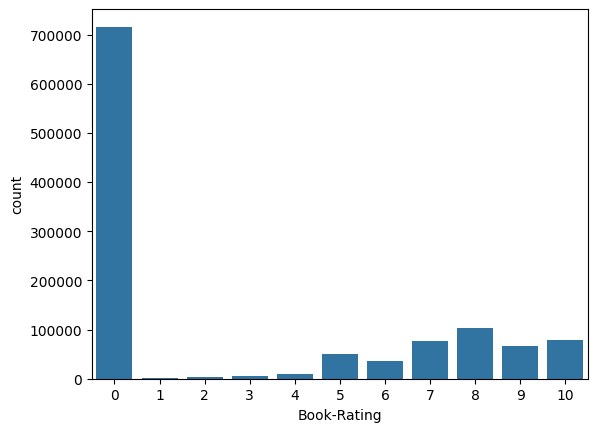

In [34]:
import matplotlib.pyplot as plt 
import seaborn as sns 

sns.countplot(x=ratings['Book-Rating']) 

In [35]:
print(len(ratings['User-ID'].unique())) 
print(len(ratings['ISBN'].unique())) 

105283
340556


Text(0, 0.5, 'Count')

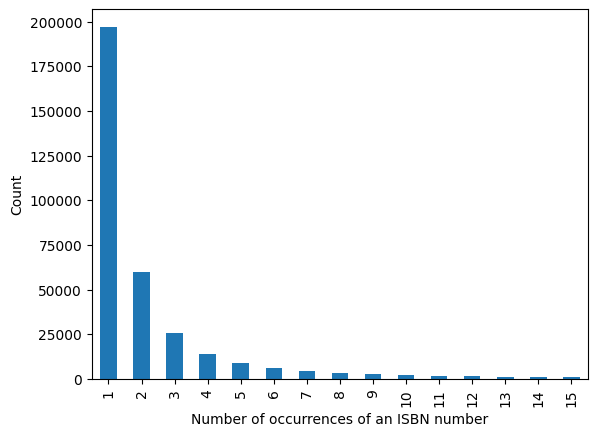

In [36]:
isbn_counts = ratings.groupby('ISBN').size()
count_occurrences = isbn_counts.value_counts()
count_occurrences[:15].plot(kind='bar')
plt.xlabel("Number of occurrences of an ISBN number")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

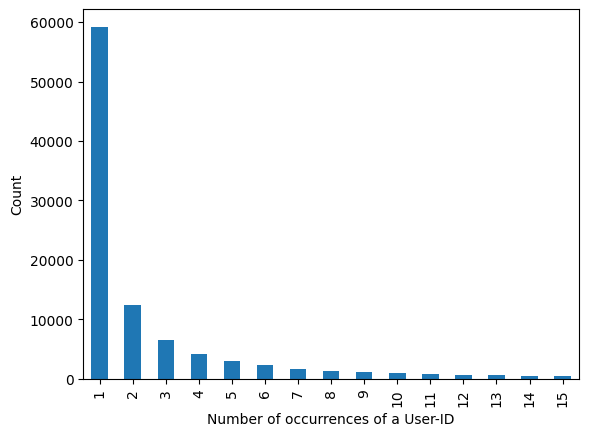

In [37]:
userid_counts = ratings.groupby('User-ID').size() 
count_occurrences = userid_counts.value_counts() 
count_occurrences[:15].plot(kind='bar')
plt.xlabel("Number of occurrences of a User-ID")
plt.ylabel("Count")

## 3.4. Preprocessing the Book-Crossing dataset

In [38]:
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from torch import nn, optim, Tensor

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn import LGConv

### 3.4.1. Use 100k highest ratings

In [40]:
# Preprocessing
ratings = ratings.loc[ratings['ISBN'].isin(books['ISBN'].unique()) & ratings['User-ID'].isin(users['User-ID'].unique())]

# Keep the 100k highest ratings
ratings = ratings[ratings['Book-Rating'] >= 8].iloc[:100000]

### 3.4.2. Create mapping

In [42]:
# Create mappings
user_mapping = {userid: i for i, userid in enumerate(ratings['User-ID'].unique())}
item_mapping = {isbn: i for i, isbn in enumerate(ratings['ISBN'].unique())}

# Count users and items
num_users = len(user_mapping)
num_items = len(item_mapping)
num_total = num_users + num_items

### 3.4.3. Adjacency matrix

In [43]:
# Build the adjacency matrix based on user ratings
user_ids = torch.LongTensor([user_mapping[i] for i in ratings['User-ID']])
item_ids = torch.LongTensor([item_mapping[i] for i in ratings['ISBN']])
edge_index = torch.stack((user_ids, item_ids))

In [44]:
# Create training, validation, and test adjacency matrices
train_index, test_index = train_test_split(range(len(ratings)), test_size=0.2, random_state=0)
val_index, test_index = train_test_split(test_index, test_size=0.5, random_state=0)

train_edge_index = edge_index[:, train_index]
val_edge_index = edge_index[:, val_index]
test_edge_index = edge_index[:, test_index]

## 3.5. Mini batch sampling

In [45]:
def sample_mini_batch(edge_index):
    # Generate BATCH_SIZE random indices
    index = np.random.choice(range(edge_index.shape[1]), size=BATCH_SIZE)

    # Generate negative sample indices
    edge_index = structured_negative_sampling(edge_index)
    edge_index = torch.stack(edge_index, dim=0)
    
    user_index = edge_index[0, index]
    pos_item_index = edge_index[1, index]
    neg_item_index = edge_index[2, index]
    
    return user_index, pos_item_index, neg_item_index

## 3.6. Implement LightGCN 

In [46]:
class LightGCN(nn.Module):
    def __init__(self, num_users, num_items, num_layers=4, dim_h=64):
        super().__init__()
        
        self.num_users = num_users
        self.num_items = num_items
        self.num_layers = num_layers
        self.emb_users = nn.Embedding(num_embeddings=self.num_users, embedding_dim=dim_h)
        self.emb_items = nn.Embedding(num_embeddings=self.num_items, embedding_dim=dim_h)

        self.convs = nn.ModuleList(LGConv() for _ in range(num_layers))

        nn.init.normal_(self.emb_users.weight, std=0.01)
        nn.init.normal_(self.emb_items.weight, std=0.01)

    def forward(self, edge_index):
        emb = torch.cat([self.emb_users.weight, self.emb_items.weight])
        embs = [emb]

        for conv in self.convs:
            emb = conv(x=emb, edge_index=edge_index)
            embs.append(emb)

        emb_final = 1/(self.num_layers+1) * torch.mean(torch.stack(embs, dim=1), dim=1)

        emb_users_final, emb_items_final = torch.split(emb_final, [self.num_users, self.num_items])

        return emb_users_final, self.emb_users.weight, emb_items_final, self.emb_items.weight

## 3.7. Loss function

In [47]:
def bpr_loss(emb_users_final, emb_users, emb_pos_items_final, emb_pos_items, emb_neg_items_final, emb_neg_items):
    reg_loss = LAMBDA * (emb_users.norm().pow(2) +
                        emb_pos_items.norm().pow(2) +
                        emb_neg_items.norm().pow(2))

    pos_ratings = torch.mul(emb_users_final, emb_pos_items_final).sum(dim=-1)
    neg_ratings = torch.mul(emb_users_final, emb_neg_items_final).sum(dim=-1)

    bpr_loss = torch.mean(torch.nn.functional.softplus(pos_ratings - neg_ratings))
    # bpr_loss = torch.mean(torch.nn.functional.logsigmoid(pos_ratings - neg_ratings))

    return -bpr_loss + reg_loss

## 3.8. Store user-item interaction in graph-based structure

In [48]:
def get_user_items(edge_index):
    user_items = dict()
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        if user not in user_items:
            user_items[user] = []
        user_items[user].append(item)
    return user_items

## 3.9. Metrics

In [49]:
def compute_recall_at_k(items_ground_truth, items_predicted):
    num_correct_pred = np.sum(items_predicted, axis=1)
    num_total_pred = np.array([len(items_ground_truth[i]) for i in range(len(items_ground_truth))])

    recall = np.mean(num_correct_pred / num_total_pred)

    return recall

In [50]:
def compute_ndcg_at_k(items_ground_truth, items_predicted):
    test_matrix = np.zeros((len(items_predicted), K))

    for i, items in enumerate(items_ground_truth):
        length = min(len(items), K)
        test_matrix[i, :length] = 1
    
    max_r = test_matrix
    idcg = np.sum(max_r * 1. / np.log2(np.arange(2, K + 2)), axis=1)
    dcg = items_predicted * (1. / np.log2(np.arange(2, K + 2)))
    dcg = np.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[np.isnan(ndcg)] = 0.
    
    return np.mean(ndcg)

In [51]:
# wrapper function to get evaluation metrics
def get_metrics(model, edge_index, exclude_edge_indices):

    ratings = torch.matmul(model.emb_users.weight, model.emb_items.weight.T)

    for exclude_edge_index in exclude_edge_indices:
        user_pos_items = get_user_items(exclude_edge_index)
        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)
        ratings[exclude_users, exclude_items] = -1024

    # get the top k recommended items for each user
    _, top_K_items = torch.topk(ratings, k=K)

    # get all unique users in evaluated split
    users = edge_index[0].unique()

    test_user_pos_items = get_user_items(edge_index)

    # convert test user pos items dictionary into a list
    test_user_pos_items_list = [test_user_pos_items[user.item()] for user in users]

    # determine the correctness of topk predictions
    items_predicted = []
    for user in users:
        ground_truth_items = test_user_pos_items[user.item()]
        label = list(map(lambda x: x in ground_truth_items, top_K_items[user]))
        items_predicted.append(label)

    recall = compute_recall_at_k(test_user_pos_items_list, items_predicted)
    ndcg = compute_ndcg_at_k(test_user_pos_items_list, items_predicted)

    return recall, ndcg

## 3.10. Evaluation function

In [52]:
# wrapper function to evaluate model
def test(model, edge_index, exclude_edge_indices):
    emb_users_final, emb_users, emb_items_final, emb_items = model.forward(edge_index)
    user_indices, pos_item_indices, neg_item_indices = structured_negative_sampling(edge_index, contains_neg_self_loops=False)

    emb_users_final, emb_users = emb_users_final[user_indices], emb_users[user_indices]

    emb_pos_items_final, emb_pos_items = emb_items_final[pos_item_indices], emb_items[pos_item_indices]
    emb_neg_items_final, emb_neg_items = emb_items_final[neg_item_indices], emb_items[neg_item_indices]

    loss = bpr_loss(emb_users_final, emb_users, emb_pos_items_final, emb_pos_items, emb_neg_items_final, emb_neg_items).item()

    recall, ndcg = get_metrics(model, edge_index, exclude_edge_indices)

    return loss, recall, ndcg

In [53]:
K = 20
LAMBDA = 1e-6
BATCH_SIZE = 1024

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LightGCN(num_users, num_items)
model = model.to(device)
edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
val_edge_index = val_edge_index.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [55]:
n_batch = int(len(train_index)/BATCH_SIZE)

for epoch in range(31):
    model.train()

    for _ in range(n_batch):
        optimizer.zero_grad()

        emb_users_final, emb_users, emb_items_final, emb_items = model.forward(train_edge_index)

        user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(train_edge_index)
        
        emb_users_final, emb_users = emb_users_final[user_indices], emb_users[user_indices]
        emb_pos_items_final, emb_pos_items = emb_items_final[pos_item_indices], emb_items[pos_item_indices]
        emb_neg_items_final, emb_neg_items = emb_items_final[neg_item_indices], emb_items[neg_item_indices]

        train_loss = bpr_loss(emb_users_final, emb_users, emb_pos_items_final, emb_pos_items, emb_neg_items_final, emb_neg_items)

        train_loss.backward()
        optimizer.step()

    if epoch % 5 == 0:
        model.eval()
        val_loss, recall, ndcg = test(model, val_edge_index, [train_edge_index])
        print(f"Epoch {epoch} | Train loss: {train_loss.item():.5f} | Val loss: {val_loss:.5f} | Val recall@{K}: {recall:.5f} | Val ndcg@{K}: {ndcg:.5f}")

Epoch 0 | Train loss: -0.69342 | Val loss: -0.69256 | Val recall@20: 0.01110 | Val ndcg@20: 0.00607
Epoch 5 | Train loss: -0.73106 | Val loss: -0.63753 | Val recall@20: 0.01841 | Val ndcg@20: 0.00861
Epoch 10 | Train loss: -0.91499 | Val loss: -0.42976 | Val recall@20: 0.01815 | Val ndcg@20: 0.00871
Epoch 15 | Train loss: -1.34274 | Val loss: -0.03908 | Val recall@20: 0.01786 | Val ndcg@20: 0.00867
Epoch 20 | Train loss: -2.16877 | Val loss: 0.49820 | Val recall@20: 0.01783 | Val ndcg@20: 0.00866
Epoch 25 | Train loss: -2.99264 | Val loss: 1.15565 | Val recall@20: 0.01794 | Val ndcg@20: 0.00867
Epoch 30 | Train loss: -4.16030 | Val loss: 1.92545 | Val recall@20: 0.01818 | Val ndcg@20: 0.00876


In [56]:
test_loss, test_recall, test_ndcg = test(model, test_edge_index.to(device), [train_edge_index, val_edge_index])

print(f"Test loss: {test_loss:.5f} | Test recall@{K}: {test_recall:.5f} | Test ndcg@{K}: {test_ndcg:.5f}")

Test loss: 1.89800 | Test recall@20: 0.01725 | Test ndcg@20: 0.00890


## 3.11. Recommend books for a particular user

In [57]:
bookid_title = pd.Series(books['Book-Title'].values, index=books.ISBN).to_dict()
bookid_author = pd.Series(books['Book-Author'].values, index=books.ISBN).to_dict()
user_pos_items = get_user_items(edge_index)

In [92]:
from PIL import Image
import requests
import torch
import matplotlib.pyplot as plt

def recommend(user_id, num_recs):
    user = user_mapping[user_id]
    emb_user = model.emb_users.weight[user]
    ratings = model.emb_items.weight @ emb_user

    values, indices = torch.topk(ratings, k=100)

    # Fetching favorite books
    ids = [index.cpu().item() for index in indices if index in user_pos_items[user]][:num_recs]
    item_isbns = [list(item_mapping.keys())[list(item_mapping.values()).index(book)] for book in ids]
    titles = [bookid_title[id] for id in item_isbns]
    authors = [bookid_author[id] for id in item_isbns]

    print(f'Favorite books from user n°{user_id}:')
    for i in range(len(item_isbns)):
        print(f'- {titles[i]}, by {authors[i]}')

    # Fetching recommended books
    ids = [index.cpu().item() for index in indices if index not in user_pos_items[user]][:num_recs]
    item_isbns = [list(item_mapping.keys())[list(item_mapping.values()).index(book)] for book in ids]
    titles = [bookid_title[id] for id in item_isbns]
    authors = [bookid_author[id] for id in item_isbns]

    print(f'\nRecommended books for user n°{user_id}')
    for i in range(num_recs):
        print(f'- {titles[i]}, by {authors[i]}')


In [93]:
recommend(277427, 5)

Favorite books from user n°277427:
- The Da Vinci Code, by Dan Brown
- Into the Wild, by Jon Krakauer
- One for the Money (Stephanie Plum Novels (Paperback)), by Janet Evanovich

Recommended books for user n°277427
- The Lovely Bones: A Novel, by Alice Sebold
- The Red Tent (Bestselling Backlist), by Anita Diamant
- Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)), by J. K. Rowling
- To Kill a Mockingbird, by Harper Lee
- Angels &amp; Demons, by Dan Brown
